In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql.types import TimestampType, BooleanType
from pyspark.sql.functions import hour, dayofmonth, size, udf
import json
from datetime import datetime
import numpy as np
from scipy.stats import chisquare

# I only do this so that Jupyter can access the SparkContext methods
sc = SparkContext.getOrCreate()

<h2>1. Read in the data</h2>
Try reading in the data via ```sc.textFile```.  You'll notice that the JSON lines are represented as maps, so our natural choice is to turn them into dict objects.  Try running spark map on the objects, and you'll notice that it throws an error.  The way to proceed is to write a function that will either return the decoded string, or ```None``` in the case that the decode fails.

In [2]:
#Several lines of the file have "" instead of a json document, 
#make a failsafe decode to prevent errors.
def failsafe_decode(row):
    try:
        return json.loads(row)
    except:
        return None

rdd = sc.textFile("./data/french_tweets.json")
print(rdd.count())
rdd = rdd.map(lambda x: failsafe_decode(x)).filter(lambda x: x!=None).cache()
print(rdd.count())


216912
214936


<h2>2. Count Tweets by User</h2>
What we'd like to do is start asking questions about how normal people are influenced by the election.  We'll start by looking at the number of tweets on a per user basis.  Create a histogram of tweets per user.

214926


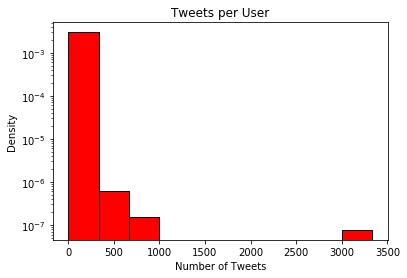

In [3]:
user_tweets = rdd.filter(lambda x:'user'  in x)\
    .filter(lambda x: 'name' in x['user']).cache()
print(user_tweets.count())
    
tweets_per_user = user_tweets.map(lambda x: (x['user']['name'], 1))\
    .reduceByKey(lambda x, y: x+y)\
    .map(lambda x: x[1])\
    .collect()

fig, ax = plt.subplots()
ax.hist(tweets_per_user, density=True, color='r', edgecolor='black')
ax.set_yscale('log')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Density')
_ = ax.set_title("Tweets per User")

<h2>3. Investigate Outliers</h2>
There seems to be an outlier.   Let's look at what it is.

In [4]:
user_tweets.map(lambda x: (x['user']['name'], 1))\
    .reduceByKey(lambda x, y: x+y)\
    .filter(lambda x: x[1]>2000)\
    .collect()

[('FOCUS Deutschland', 3337)]

<h2>4. Clean Data to Make a More Representative Distribution</h2> 
This looks like a News organization.  Let's drop it and look at the remaining portion of the distribution.  Since we can see that even in the portion that will be left, there is most likely a very long tail.  Let's make two histograms, based on some split.

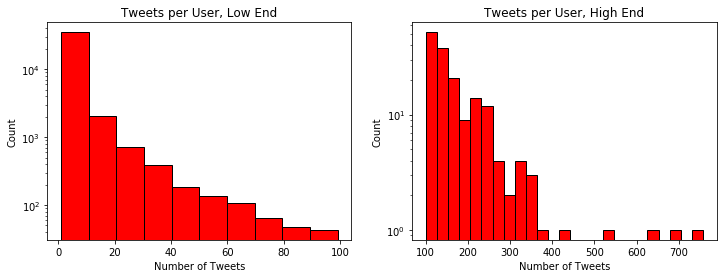

In [5]:
tweets_per_user = user_tweets.map(lambda x: (x['user']['name'], 1))\
    .reduceByKey(lambda x, y: x+y)\
    .filter(lambda x: x[1]<2000)\
    .map(lambda x: x[1])\
    .collect()
    
fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].hist([x for x in tweets_per_user if x<100], bins=10, color='r', edgecolor='black')
ax[0].set_yscale('log')
ax[0].set_xlabel('Number of Tweets')
ax[0].set_ylabel('Count')
ax[0].set_title("Tweets per User, Low End")

ax[1].hist([x for x in tweets_per_user if x>100], bins = 25, color='r', edgecolor='black')
ax[1].set_yscale('log')
ax[1].set_xlabel('Number of Tweets')
ax[1].set_ylabel('Count')
_ = ax[1].set_title("Tweets per User, High End")

<h2>5. Create a 'User Stoplist'</h2>
We want to find the small number of users who tweet disproportionately more than the normal population.  Based on the above distribution, 280 seems like a reasonable place to make the cutoff as there seems to be a falloff at that point.  You can then filter out tweets from those users, and see the effect on your sample size.

In [6]:
power_users = user_tweets.map(lambda x: (x['user']['name'], 1))\
    .reduceByKey(lambda x, y: x+y)\
    .filter(lambda x: x[1] > 280)\
    .map(lambda x: x[0])\
    .collect()
    
print(power_users)

bc_pus = sc.broadcast(set(power_users))
user_tweets = user_tweets.filter(lambda x: x['user']['name'] not in bc_pus.value).cache()
user_tweets.count()

['Média Soignant', 'Sylvie-T 🌹', 'रवि कांत', 'Trendinalia France', 'Acram', 'cavaleyra', 'Huey Freeman #HHR', 'franck jt', 'RomainDesbois', 'Akije Hirodi Ω', 'SweetSosoFanzouze', 'MACRON serial-crims', 'FOCUS Deutschland', 'Louise Sautron Lebon', '.', 'Fujito🐭']


205230

<h2>6. Convert your RDD to a DataFrame</h2>
Scanning the remaining items, the only two fields we leverage are the list of hashtags, and the post datetime.  Note the cleanup for the hashtag list, particularly merging the tags tpmp and tpmp1000 (associated tags for the same singing competition). 

In [7]:
def json_to_row(rdd):
    return Row(creation_date=datetime.strptime(rdd['created_at'], '%a %b %d %X %z %Y'),\
               hashtag_list=[y['text'].lower() if y['text'].lower() != 'tpmp' else 'tpmp1000' for y in rdd['entities']['hashtags'] ])

df = sqlContext.createDataFrame(user_tweets.map(lambda x: json_to_row(x)))
df.head(10)

[Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 45), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 45), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 46), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 46), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 47), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 47), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 47), hashtag_list=['alleyezonit', 'neochrome', 'eriah', 'loin', 'youtube', 'youtubeneochrome', 'repdom']),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 48), hashtag_list=['rncmobile']),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 48), hashtag_list=[]),
 Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 49), hashtag_list=[])]

<h2>7. Plot Timeline</h2>
For the remaining Tweets, create a timeline for when the Tweets are created.

In [8]:
time_counts = df.groupBy(dayofmonth(df.creation_date), hour(df.creation_date))\
                .agg({"*": "count"})\
                .sort('dayofmonth(creation_date)', 'hour(creation_date)')\
                .rdd.map(lambda x: ((x['dayofmonth(creation_date)'], x['hour(creation_date)']), x['count(1)']))\
                .collect()
        
time_counts[:3]

[((26, 8), 655), ((26, 9), 2206), ((26, 10), 5225)]

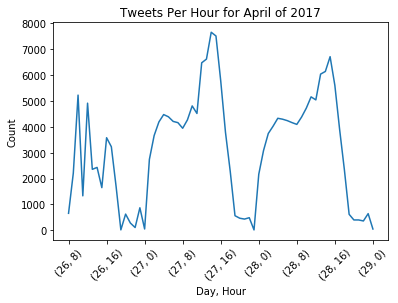

In [9]:
xs = [x for x in range(len(time_counts))]
ys = [x[1] for x in time_counts]
labels = [(x[0][0], x[0][1]) for x in time_counts]


def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return labels[int(tick_val)]
    else:
        return ''


fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for tick in ax.get_xticklabels():
        tick.set_rotation(45)
ax.plot(xs, ys)
ax.set_xlabel('Day, Hour')
ax.set_ylabel('Count')
ax.set_title('Tweets Per Hour for April of 2017')
plt.show()

Note that data collection on the day of the 26th looks irregular.  For the later portions when examining hourly rates, we will restrict our views to the 27th and 28th.

<h2>8. Identify Tweets With Hashtags</h2>
Instead of looking at the actual text of the Tweets, we will rely on the existence of hashtags.  Twitter automatically pulls out links, hashtags, mentions, and symbols. Let's start by filtering the data to eliminate any of the entries where there are no hashtags. 

In [10]:
print(df.count())
hashtag_tweets = df.filter(size('hashtag_list')>0).cache()
n_total = hashtag_tweets.count()
print(n_total)

205230
45479


We're left with a much smaller subset.  Let's now find the most common hashtags.  'Le Pen' is not in the top ten, we must extend to the top 15.

In [11]:
hashtag_tweets.head()

Row(creation_date=datetime.datetime(2017, 4, 26, 8, 30, 47), hashtag_list=['alleyezonit', 'neochrome', 'eriah', 'loin', 'youtube', 'youtubeneochrome', 'repdom'])

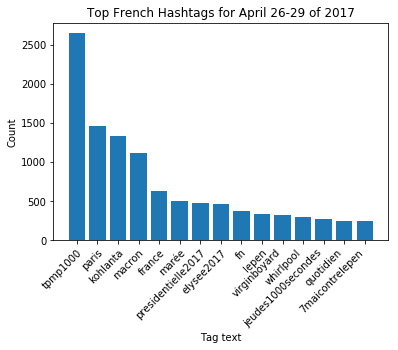

In [12]:
tags = hashtag_tweets.rdd.flatMap(lambda x: x['hashtag_list'])\
                     .map(lambda x: (x, 1))\
                     .reduceByKey(lambda x, y: x+y)\
                     .sortBy(lambda x: x[1], ascending=False)\
                     .take(15)
                
xs = [x for x in range(len(tags))]
ys = [x[1] for x in tags]
labels = [x[0] for x in tags]
fig, ax = plt.subplots()
ax.bar(xs, ys)
ax.set_xticklabels(labels, rotation=45, rotation_mode="anchor", ha="right")
ax.set_xticks(xs)
ax.set_xlabel('Tag text')
ax.set_ylabel('Count')
ax.set_title('Top French Hashtags for April 26-29 of 2017')
plt.show()

Note, we may be being a little bit too literal here.  "Marée" is "Tide" in French, and I *think* it may be associated with Marie Le Pen (in the same way MAGA was associated with Trump in 2016).  This is a good example of when interfacing with a subject matter expert would be a good idea, and this visualization allows us to give an unbiased representation of what we observe.

<h2>9. Calculate Macron-Le Pen PMI</h2>

In [13]:
def has_names(name, l_hashtags):
    if name not in l_hashtags:
            return False
    return True

has_macron = udf(lambda l_hashtags: has_names('macron', l_hashtags), BooleanType())
has_lepen = udf(lambda l_hashtags: has_names('lepen', l_hashtags), BooleanType())

In [14]:
hashtag_tweets = hashtag_tweets.withColumn('macron', has_macron(hashtag_tweets['hashtag_list']))\
                               .withColumn('lepen', has_lepen(hashtag_tweets['hashtag_list']))


hashtag_tweets.filter(hashtag_tweets.macron==True).head()

Row(creation_date=datetime.datetime(2017, 4, 26, 8, 32, 31), hashtag_list=['macron'], macron=True, lepen=False)

In [15]:
n_both = hashtag_tweets.filter((hashtag_tweets.macron==True) & (hashtag_tweets.lepen==True)).count()
n_mac = hashtag_tweets.filter(hashtag_tweets.macron==True).count()
n_lep = hashtag_tweets.filter(hashtag_tweets.lepen==True).count()
pmi = np.log2(n_total*n_both/(n_mac*n_lep))
print("PMI for #macron and #lepen:", pmi)

PMI for #macron and #lepen: 3.779735490263036


The raw PMI score is a bit challenging to interpret.  Luckily, we can normalize by dividing by the total self information.  The score is restricted to [-1, 1].  

In [16]:
h_mac = -np.log2(n_mac/n_total)
h_lep = -np.log2(n_lep/n_total)
h_both = h_mac + h_lep - pmi
print("Normalized PMI: {0:.4f}".format(pmi/h_both))

Normalized PMI: 0.4375


A score of ~.44 means that they convey much of the same meaning (i.e. the French election).

<h2>10. Show Hashtags by Hour</h2>
Recall that in part 6 we noted the stated we would restrict our analysis to the 27th and 28th since it is they are complete days without interruption.

In [18]:
tags_to_keep = sc.broadcast(set(labels))

hashtag_tweets.filter((dayofmonth(hashtag_tweets.creation_date)==27) | (dayofmonth(hashtag_tweets.creation_date)==28)).cache()

tags_hours = hashtag_tweets.rdd.flatMap(lambda x: [(x.creation_date.hour, y) for y in x.hashtag_list])\
            .filter(lambda x: x[1] in tags_to_keep.value)\
            .map(lambda x: (x, 1))\
            .reduceByKey(lambda x, y: x+y)\
            .collect()
            
#it is likely that for several hours/tags we'll need to zero-fill our data
print(len(tags_hours), 15*24)

missing =set([(i, tag) for i in range(24) for tag in labels]).difference([x[0] for x in tags_hours]) 
for m in list(missing):
    tags_hours.append((m, 0))
    
print(len(tags_hours), 15*24)

280 360
360 360


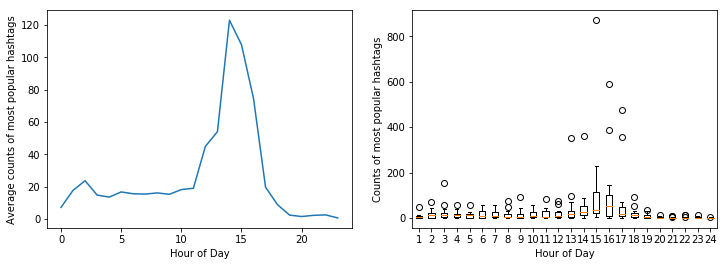

In [19]:
tag_by_hour = {k:[] for k in range(24)}
for i in tags_hours:
    tag_by_hour[i[0][0]].append(i[1])

data = np.array([tag_by_hour[x] for x in range(24)])
fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].plot([np.mean(x) for x in data])
ax[0].set_xlabel("Hour of Day")
ax[0].set_ylabel("Average counts of most popular hashtags")
ax[1].boxplot([x for x in data])
ax[1].set_xlabel("Hour of Day")
_ = ax[1].set_ylabel("Counts of most popular hashtags")

It's clear from the two visualizations that the averages over the day are being dominated by the outliers, and that the true distribution is more flatter.

<h2>11. Hashtag Time Line Comparison</h2>
Let's look at the comparisons of time for Macron and Le Pen.

In [48]:
def fill_missing_hours(l_ht_by_hour):
    for hour in range(24):
        if hour == len(l_ht_by_hour):
            l_ht_by_hour.append((hour, 0))
        elif l_ht_by_hour[hour][0] != hour:
            l_ht_by_hour.insert(hour, (hour, 0))

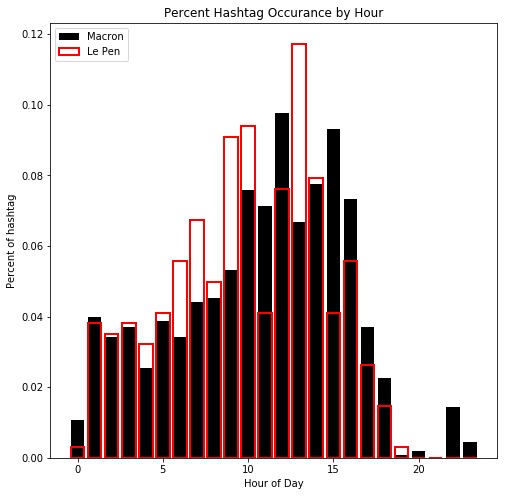

In [59]:
macron = hashtag_tweets.filter(hashtag_tweets.macron==True)\
              .groupBy(hour('creation_date'))\
              .agg({"*": "count"})\
              .sort('hour(creation_date)')\
              .rdd.map(lambda x: (x['hour(creation_date)'], x['count(1)']))\
              .collect()            
            
lepen = hashtag_tweets.filter(hashtag_tweets.lepen==True)\
              .groupBy(hour('creation_date'))\
              .agg({"*": "count"})\
              .sort('hour(creation_date)')\
              .rdd.map(lambda x: (x['hour(creation_date)'], x['count(1)']))\
              .collect()

fill_missing_hours(macron)
fill_missing_hours(lepen)

macron = np.array(macron)[:, 1]
lepen = np.array(lepen)[:, 1]

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.bar([x for x in range(24)], macron/np.sum(macron), color='black', label = 'Macron')
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Percent of hashtag")
ax.bar([x for x in range(24)], lepen/np.sum(lepen), fill=False, edgecolor='red', linewidth=2.0, label='Le Pen')
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Percent of hashtag")
ax.set_title("Percent Hashtag Occurance by Hour")
_ = ax.legend(loc='upper left')

In [62]:
stat, p = chisquare(macron[:19], lepen[:19])
print("The p-value that these distributions are identically distributed: ", p)

The p-value that these distributions are identically distributed:  0.0


The distributions are independent.  My interpretation is that the conversation is not simply an ongoing argument, and that people tweet about the two candidates independently.